In [25]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("..")

os.environ['CUDA_VISIBLE_DEVICES']='1'
os.environ['MUJOCO_GL']='egl'

%load_ext autoreload
%autoreload 2
import jax.numpy as jnp

from envs.maze_envs import CustomPointUMazeSize3Env, CustomAntUMazeSize3Env
source_env = CustomPointUMazeSize3Env()
target_env = CustomAntUMazeSize3Env()

source_env.reset(42, None)
target_env.reset(42, None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(array([ 0.05479121, -0.01222431,  0.8217196 ,  0.99160886, -0.07742714,
         0.09074426,  0.049823  ,  0.05721286, -0.07437728, -0.00992281,
        -0.0258404 ,  0.08535299,  0.02877302,  0.06455232, -0.01131716,
         1.3140707 ,  1.3140707 ,  1.3140707 ,  1.3140707 ,  1.3140707 ,
         1.3140707 ,  1.3140707 ,  1.3140707 ,  1.3140707 ,  1.3140707 ,
         1.3140707 ,  1.3140707 ,  1.3140707 ,  1.3140707 ,  0.        ],
       dtype=float32),
 None)

In [26]:
## Source PointUMaze; Target AntUMaze
from datasets.dataset import Dataset

expert_source = np.load("../prep_data/pointumaze/expert_source/trained_expert.npy", allow_pickle=True).item()
random_source = np.load("../prep_data/pointumaze/rand_source/random_policy.npy", allow_pickle=True).item()
random_target = np.load("../prep_data/pointumaze/rand_target/random_policy.npy", allow_pickle=True).item()

expert_source_ds = Dataset(observations=expert_source['observations'],
                           actions=expert_source['actions'],
                           rewards=expert_source['rewards'],
                           dones_float=expert_source['dones'],
                           masks=1.0 - expert_source['dones'],
                           next_observations=expert_source['next_observations'],
                           size=expert_source['observations'].shape[0])

non_expert_source_ds = Dataset(observations=random_source['observations'],
                           actions=random_source['actions'],
                           rewards=random_source['rewards'],
                           dones_float=random_source['dones'],
                           masks=1.0 - random_source['dones'],
                           next_observations=random_source['next_observations'],
                           size=random_source['observations'].shape[0])

agent_target_ds = Dataset(observations=random_target['observations'],
                           actions=random_target['actions'],
                           rewards=random_target['rewards'],
                           dones_float=random_target['dones'],
                           masks=1.0 - random_target['dones'],
                           next_observations=random_target['next_observations'],
                           size=random_target['observations'].shape[0])

In [27]:
print(agent_target_ds.observations.shape[-1])
print(expert_source_ds.observations.shape[-1])
print(non_expert_source_ds.observations.shape[-1])

30
7
7


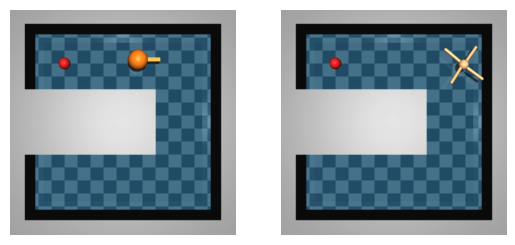

In [28]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
source_env.wrapped_env.set_xy(expert_source['observations'][30, :2])
target_env.wrapped_env.set_xy(random_target['observations'][900, :2])
axs[0].imshow(source_env.render('rgb_array'))
axs[1].imshow(target_env.render('rgb_array'))

axs[0].axis('off')
axs[1].axis('off')
plt.savefig("env.png")

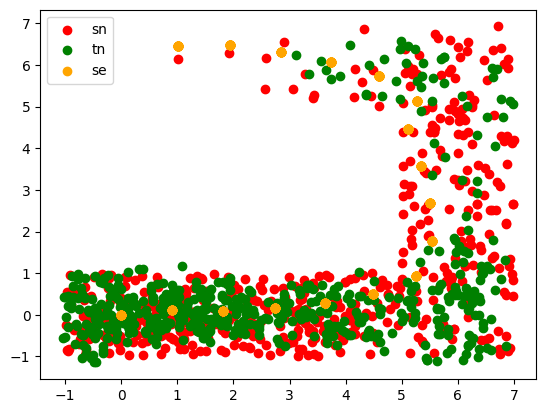

In [29]:
agent_data = agent_target_ds.sample(512)
expert_data = expert_source_ds.sample(512)
random_data = non_expert_source_ds.sample(512)

fig, ax = plt.subplots()

tn_pos = (agent_data.observations[:, 0], agent_data.observations[:, 1])
sn_pos = (random_data.observations[:, 0], random_data.observations[:, 1])
se_pos = (expert_data.observations[:, 0], expert_data.observations[:, 1])

ax.scatter(*sn_pos, c='red', label='sn')
ax.scatter(*tn_pos, c='green', label='tn')
ax.scatter(*se_pos, c='orange', label='se')

#ax.plot(map.ox, map.oy, '.k')
plt.legend()
plt.show()

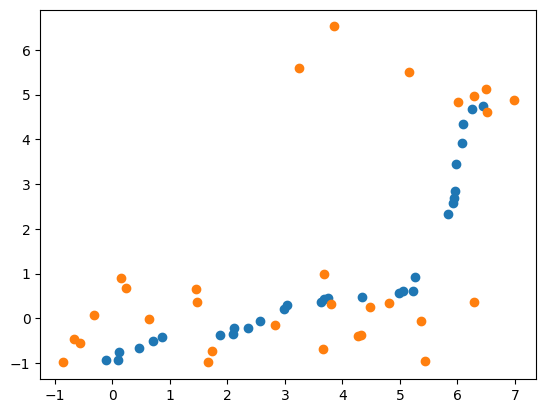

In [30]:
fig, ax = plt.subplots()
random_data1 = non_expert_source_ds.sample(30).observations
random_data = np.sort(non_expert_source_ds.sample(30).observations, axis=0)
ax.scatter(random_data[:, 0], random_data[:, 1])
ax.scatter(random_data1[:, 0], random_data1[:, 1])

In [37]:
from orbax.checkpoint import PyTreeCheckpointer

import nest_asyncio
nest_asyncio.apply()

checkpointer = PyTreeCheckpointer()
restored_ckpt = checkpointer.restore("/home/m_bobrin/CrossDomainIL/outputs/2024-04-21/15-07-38/saved_model")

In [64]:
from icvf_utils.icvf_networks import create_icvf
from jaxrl_m.common import TrainState

value_def = create_icvf("multilinear", hidden_dims=[512, 512, 512], ensemble=True)
value = TrainState.create(value_def, params=restored_ckpt['value']['params'])

In [68]:
value(agent_target_ds.observations[0, :], agent_target_ds.observations[5, :], agent_target_ds.observations[10, :]).mean()

Array(-6.280109, dtype=float32)

In [88]:
value(agent_target_ds.observations[0, :], agent_target_ds.observations[250, :], agent_target_ds.observations[54, :]).mean()

Array(-33.995903, dtype=float32)

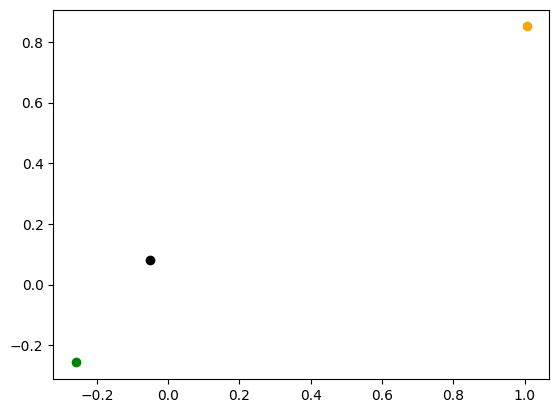

In [89]:
fig, ax = plt.subplots()
ax.scatter(agent_target_ds.observations[0, 0], agent_target_ds.observations[0, 1], c='black')
ax.scatter(agent_target_ds.observations[54, 0], agent_target_ds.observations[54, 1], c='green')
ax.scatter(agent_target_ds.observations[250, 0], agent_target_ds.observations[250, 1], c='orange')

In [6]:
import ott
import optax
from IPython.display import clear_output, display
from ott.geometry import pointcloud
from ott.neural.methods import neuraldual
from ott.neural.networks import potentials, icnn
from ott.tools import sinkhorn_divergence

(se_iter, sn_iter, ta_iter) = expert_source_ds.get_iter(batch_size=1024), non_expert_source_ds.get_iter(batch_size=1024), \
                                                                      agent_target_ds.get_iter(batch_size=1024)
ta_eval_data = next(ta_iter)
se_eval_data = next(se_iter)
 
# def train_call(step, dual_pot):
#     if step % 1000:
#         fig, ax = dual_pot.plot_ot_map(
#             ta_eval_data, 
#             se_eval_data,
#             forward=True
#         )
#         display(fig)
#         plt.close(fig)
#         fig, ax = dual_pot.plot_potential()
#         display(fig)
#         plt.close(fig)
                                                                     
neural_f = potentials.PotentialMLP(
    dim_hidden=[128, 128, 128, 128],
    is_potential=True
)
neural_g = potentials.PotentialMLP(
    dim_hidden=[128, 128, 128, 128],
    is_potential=True
)
optimizer_f = optax.adam(learning_rate=2e-4, b1=0.9, b2=0.9)
optimizer_g = optax.adam(learning_rate=2e-4, b1=0.9, b2=0.99)

neural_dual_solver = neuraldual.W2NeuralDual(
    dim_data=2, 
    neural_f=neural_f,
    neural_g=neural_g,
    optimizer_f=optimizer_f,
    optimizer_g=optimizer_g,
    num_train_iters=10_000,
)
learned_pot = neural_dual_solver(*(ta_iter, se_iter), *(ta_iter, se_iter), callback=None)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
import jax
jax.vmap(learned_pot.f)(ta_eval_data[:5])

Array([18.157946 , -9.626131 , -2.6177032, 18.860611 ,  3.897844 ],      dtype=float32)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

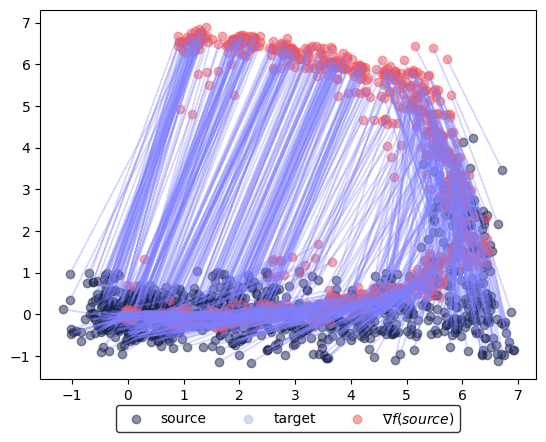

In [12]:
learned_pot.plot_ot_map(ta_eval_data, se_eval_data)

# NOT

In [16]:
from ott.neural.solvers.neuraldual import W2NeuralDual
import jax.numpy as jnp
import jax

class W2NeuralDualCustom(W2NeuralDual):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.back_and_forth = True
        self.step = 0
    
    def update(self, batch_agent, batch_expert):

        update_forward = not self.back_and_forth or self.step % 2 == 0
        train_batch = {}

        if update_forward:
            train_batch["source"] = batch_agent
            train_batch["target"] = batch_expert
            (self.state_f, self.state_g, loss, loss_f, loss_g, w_dist) = self.train_step_parallel(
                self.state_f,
                self.state_g,
                train_batch,
            )
        else:
            train_batch["target"] = batch_agent
            train_batch["source"] = batch_expert
            (self.state_g, self.state_f, loss, loss_f, loss_g, w_dist) = self.train_step_parallel(
                self.state_g,
                self.state_f,
                train_batch,
            )

        self.step += 1
       
        return self, loss, w_dist

In [17]:
import jax
from networks.common import LayerNormMLP, TrainState, MLP
import jax.numpy as jnp
import optax
import flax.linen as nn
from flax.struct import PyTreeNode
from typing import Sequence, Dict
from ott.neural.solvers.neuraldual import W2NeuralDual
from ott.neural import models

class Encoders(nn.Module):
    encoders: Dict[str, nn.Module]
    
    def encode_expert(self, expert_states):
        return self.encoders['expert_encoder'](expert_states)
    
    def encode_agent(self, agent_states):
        return self.encoders['agent_encoder'](agent_states)
    
    def __call__(self, agent_obs, expert_obs):
        rets = {
            "encoded_agent": self.encode_agent(agent_obs),
            "encoded_expert": self.encode_expert(expert_obs)
        }
        return rets

def ot_distance_pairs(learned_potentials, x, y, x_next, y_next, sa_next, sa):
    #JointAgent.ot_distance_pairs(potentials_pairs, sn, se, sn_next, se_next, sa_next, sa)
    # [sa, sn], [se, se], [sa_next, sn_next], [se_next, se_next]
    x_pair = jnp.concatenate([x, x_next], axis=-1)
    y_pair = jnp.concatenate([y, y_next], axis=-1)
    sa_next = jnp.concatenate([sa, sa_next], axis=-1)
    
    return learned_potentials.distance(jnp.concatenate([sa_next, x_pair]), jnp.concatenate([y_pair, y_pair]))

def encoders_loss(potentials_elem, potentials_pairs, sa, se, sn, sa_next, se_next, sn_next, expert_loss_coef):
    
    loss_elem = JointAgent.ot_distance_elements(
        potentials_elem, 
        jnp.concatenate([sa, sa], axis=0), 
        jnp.concatenate([sn, sn], axis=0),  # se
    )
    #[sa, sn], [se, se], [sa_next, sn_next], [se_next, se_next]
    loss_pairs = ot_distance_pairs(potentials_pairs, sn, se, sn_next, se_next, sa_next, sa)
    # expert_enc_loss = JointAgent.compute_expert_encoder_loss(potentials_pairs, y, y_next)
    
    loss = loss_elem - loss_pairs * expert_loss_coef

    return loss, loss_elem, loss_pairs

@jax.jit
def compute_embeds(encoders, batch_agent, batch_expert, random_data):
    se = encoders(batch_expert.observations, method='encode_expert')
    se_next = encoders(batch_expert.next_observations, method='encode_expert')
    sn = encoders(random_data.observations, method='encode_expert')
    sn_next = encoders(random_data.next_observations, method='encode_expert')
    sa = encoders(batch_agent.observations, method='encode_agent')
    sa_next = encoders(batch_agent.next_observations, method='encode_agent')

    sa_pairs = jnp.concatenate([sa, sa_next], axis=-1)
    se_pairs = jnp.concatenate([se, se_next], axis=-1)
    sn_pairs = jnp.concatenate([sn, sn_next], axis=-1)

    return  sa, se, sn, sa_pairs, se_pairs, sn_pairs

class JointAgent:
    def __init__(
        self,
        encoder_agent: nn.Module,
        encoder_expert: nn.Module,
        agent_dim: int,
        expert_dim: int,
        embed_dim: int,
        neural_f: nn.Module,
        neural_g: nn.Module,
        optimizer_f,
        optimizer_g,
        expert_loss_coef: float = 1.,
        learning_rate: float = 1e-4,
        rng = jax.random.PRNGKey(42)) -> None:

        self.expert_loss_coef = expert_loss_coef

        encoders = Encoders({
            'agent_encoder': encoder_agent,
            'expert_encoder': encoder_expert
        })

        self.encoders_state = TrainState.create(
            model_def=encoders,
            params=encoders.init(rng, jnp.ones(agent_dim), jnp.ones(expert_dim))['params'],
            tx=optax.adam(learning_rate=learning_rate)
        )

        self.neural_dual_elements = W2NeuralDualCustom(
            dim_data=embed_dim, 
            neural_f=neural_f,
            neural_g=neural_g,
            optimizer_f=optimizer_f,
            optimizer_g=optimizer_g,
            num_train_iters=10_000
        )

        self.neural_dual_pairs = W2NeuralDualCustom(
            dim_data=embed_dim * 2, 
            neural_f=neural_f,
            neural_g=neural_g,
            optimizer_f=optimizer_f,
            optimizer_g=optimizer_g,
            num_train_iters=10_000
        )

    @staticmethod
    def ot_distance_elements(learned_potentials, x, y):
        return learned_potentials.distance(x, y)

    @staticmethod
    def compute_expert_encoder_loss(learned_potentials, y, y_next): # maximize target potential g w.r.t encoder
        y_pair = jnp.concatenate([y, y_next], axis=-1)
        g_value = jax.vmap(learned_potentials.g)(y_pair)
        return jnp.mean((y_pair ** 2).sum(-1)) - 2 * jnp.mean(g_value)
    
    # @staticmethod
    # def encoders_loss(potentials_elem, potentials_pairs, sa, se, sn, sa_next, se_next, sn_next, expert_loss_coef):
        
    #     loss_elem = JointAgent.ot_distance_elements(
    #         potentials_elem, 
    #         jnp.concatenate([sa, sa], axis=0), 
    #         jnp.concatenate([se, sn], axis=0), 
    #     )
    #     loss_pairs = JointAgent.ot_distance_pairs(potentials_pairs, sn, se, sn_next, se_next)
    #     # expert_enc_loss = JointAgent.compute_expert_encoder_loss(potentials_pairs, y, y_next)
        
    #     loss = loss_elem - loss_pairs * expert_loss_coef

    #     return loss, loss_elem, loss_pairs
        
    def optimize_not(self, batch_agent, batch_expert, random_data):
        sa, se, sn, sa_pairs, se_pairs, sn_pairs = compute_embeds(self.encoders_state, batch_agent, batch_expert, random_data)
        _, loss_elem, w_dist_elem = self.neural_dual_elements.update(np.concatenate([sa, sa]), np.concatenate([se, sn]))
        _, loss_pairs, w_dist_pairs = self.neural_dual_pairs.update(np.concatenate([sa_pairs, sn_pairs]), np.concatenate([se_pairs, se_pairs]))
        
        return loss_elem, loss_pairs, w_dist_elem, w_dist_pairs
    
    def optimize_encoders(self, batch_agent, batch_expert, random_data):
        @jax.jit
        def update_step(potentials_elem, potentials_pairs, encoders, batch_agent, batch_expert, random_data):
            def loss_fn(params):
                se = encoders(batch_expert.observations, params=params, method='encode_expert')
                se_next = encoders(batch_expert.next_observations, params=params, method='encode_expert')
                sa = encoders(batch_agent.observations, params=params, method='encode_agent')
                sa_next = encoders(batch_agent.next_observations, params=params, method='encode_agent')
                sn = encoders(random_data.observations, method='encode_expert')
                sn_next = encoders(random_data.next_observations, method='encode_expert')

                loss, not_loss, expert_enc_loss = encoders_loss(potentials_elem, potentials_pairs, sa, se, sn, sa_next, se_next, sn_next, self.expert_loss_coef)

                return loss, {'loss': loss,
                            'not_distance': not_loss,
                            'expert_encoder_loss': expert_enc_loss}
            
            new_encoders, info = encoders.apply_loss_fn(loss_fn=loss_fn, has_aux=True)

            return new_encoders, info
        
        potentials_elem = self.neural_dual_elements.to_dual_potentials()
        potentials_pairs = self.neural_dual_pairs.to_dual_potentials()

        self.encoders_state, info = update_step(
            potentials_elem, potentials_pairs, self.encoders_state, batch_agent, batch_expert, random_data
        )
        
        return info

In [7]:
rng = jax.random.PRNGKey(42)

enc1_key, enc2_key = jax.random.split(rng, 2)

hidden_dims = [64, 64, 32, 16, 8, 2]
encoder_expert = LayerNormMLP(hidden_dims=hidden_dims, activations=jax.nn.leaky_relu)
encoder_agent = LayerNormMLP(hidden_dims=hidden_dims, activations=jax.nn.leaky_relu)


neural_f = models.MLP(
    dim_hidden=[128, 128, 128, 128],
    is_potential=True,
)
neural_g = models.MLP(
    dim_hidden=[128, 128, 128, 128],
    is_potential=True,
)
# lr_schedule = optax.cosine_decay_schedule(
#     init_value=1e-4, decay_steps=5, alpha=1e-2
# )
optimizer_f = optax.adam(learning_rate=1e-4, b1=0.9, b2=0.99)
optimizer_g = optimizer_f

agent = JointAgent(
    encoder_agent, 
    encoder_expert, 
    target_env.observation_space.shape[0], 
    source_env.observation_space.shape[0],
    hidden_dims[-1],
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g)

2024-04-16 15:08:12.760693: W external/xla/xla/service/gpu/runtime/support.cc:58] Intercepted XLA runtime error:
INTERNAL: jaxlib/gpu/solver_kernels.cc:45: operation gpusolverDnCreate(&handle) failed: cuSolver internal error
2024-04-16 15:08:12.760723: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2716] Execution of replica 0 failed: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.custom_call' failed: jaxlib/gpu/solver_kernels.cc:45: operation gpusolverDnCreate(&handle) failed: cuSolver internal error; current tracing scope: custom-call.7; current profiling annotation: XlaModule:#prefix=jit(qr)/jit(main),hlo_module=jit_qr,program_id=11#.


XlaRuntimeError: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.custom_call' failed: jaxlib/gpu/solver_kernels.cc:45: operation gpusolverDnCreate(&handle) failed: cuSolver internal error; current tracing scope: custom-call.7; current profiling annotation: XlaModule:#prefix=jit(qr)/jit(main),hlo_module=jit_qr,program_id=11#.

In [8]:
from ott.tools import sinkhorn_divergence
from ott.geometry import pointcloud

@jax.jit
def sinkhorn_loss(
    x: jnp.ndarray, y: jnp.ndarray, epsilon: float = 0.001
) -> float:
    """Computes transport between (x, a) and (y, b) via Sinkhorn algorithm."""
    a = jnp.ones(len(x)) / len(x)
    b = jnp.ones(len(y)) / len(y)

    sdiv = sinkhorn_divergence.sinkhorn_divergence(
        pointcloud.PointCloud, x, y, epsilon=epsilon, a=a, b=b
    )
    return sdiv.divergence


In [6]:
import matplotlib.pyplot as plt

agent_data = agent_target_ds.sample(512)
expert_data = expert_source_ds.sample(512)
random_data = non_expert_source_ds.sample(512)

sn = agent.encoders_state(random_data.observations, method='encode_expert')
se = agent.encoders_state(expert_data.observations, method='encode_expert')
tn = agent.encoders_state(agent_data.observations, method='encode_agent')

fig, ax = plt.subplots()
ax.scatter(sn[:, 0], sn[:, 1], c='red', label='sn')
ax.scatter(tn[:, 0], tn[:, 1], c='green', label='tn')
ax.scatter(se[:, 0], se[:, 1], c='orange', label='se')
plt.legend()
plt.show()

NameError: name 'agent' is not defined

In [11]:
from tqdm.notebook import tqdm

pbar = tqdm(range(1_000), leave=True)
for i in pbar:
    agent_data = agent_target_ds.sample(512)
    expert_data = expert_source_ds.sample(512)
    random_data = non_expert_source_ds.sample(512)
    loss_elem, loss_pairs, w_dist_elem, w_dist_pairs = agent.optimize_not(agent_data, expert_data, random_data)

    if i % 100 == 0:
        se = agent.encoders_state(expert_data.observations, method='encode_expert')
        sa = agent.encoders_state(agent_data.observations, method='encode_agent')
        sink = sinkhorn_loss(sa, se)
        pbar.set_postfix({"sink_dist": sink,
                          "w_dist_elem": w_dist_elem})
        #print(loss_elem, loss_pairs, w_dist_elem, w_dist_pairs, sink)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
from tqdm.notebook import tqdm

pbar = tqdm(range(1_000), leave=True)
for i in pbar:
    agent_data = agent_target_ds.sample(512)
    expert_data = expert_source_ds.sample(512)
    random_data = non_expert_source_ds.sample(512)
    loss_elem, loss_pairs, w_dist_elem, w_dist_pairs = agent.optimize_not(agent_data, expert_data, random_data)

    if i % 100 == 0:
        se = expert_data.observations[:, :2]
        sa = agent_data.observations[:, :2]
        sink = sinkhorn_loss(sa, se)
        pbar.set_postfix({"sink_dist": sink,
                          "w_dist_elem": w_dist_elem})
        #print(loss_elem, loss_pairs, w_dist_elem, w_dist_pairs, sink)


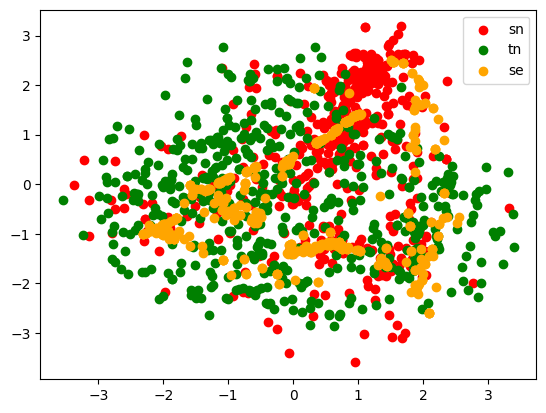

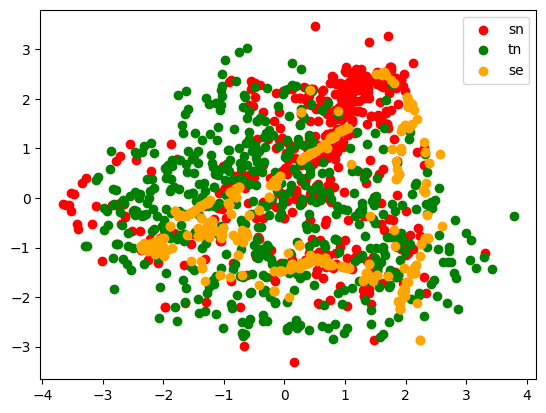

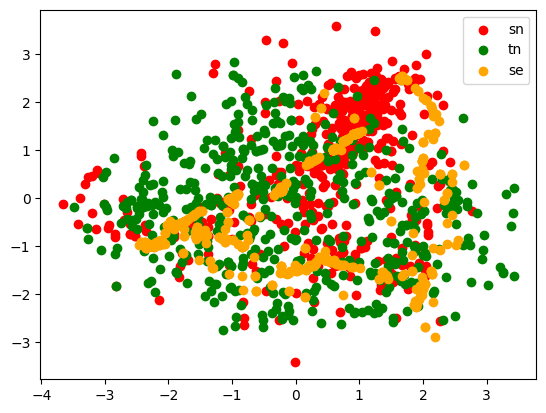

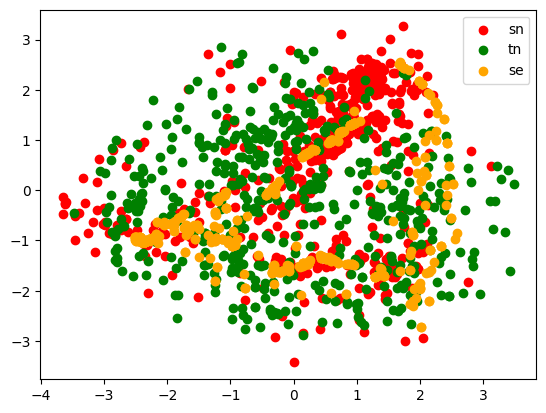

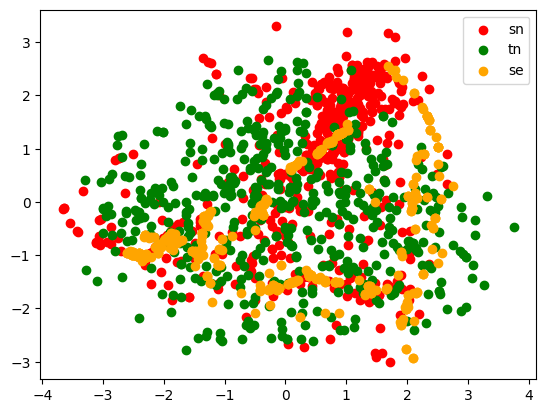

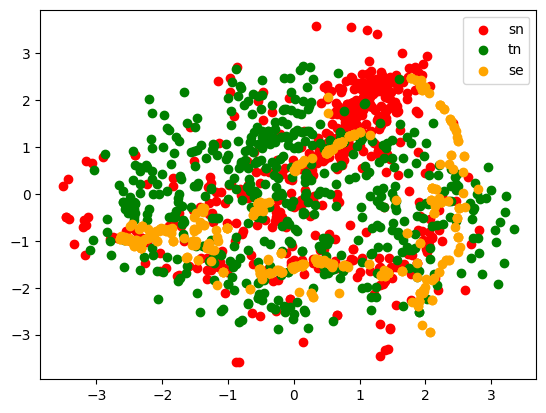

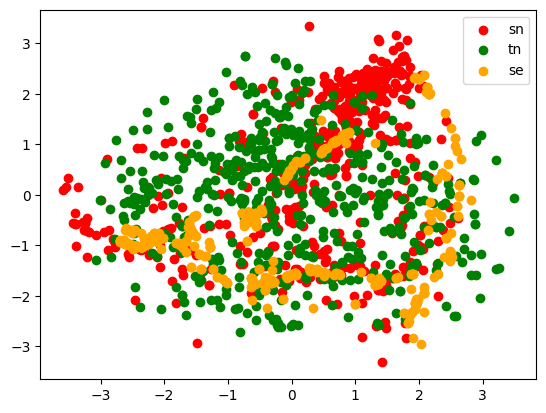

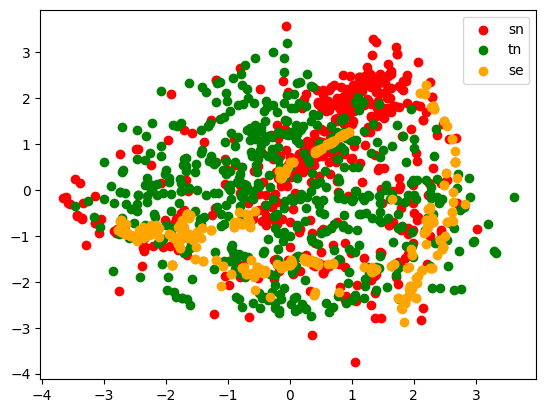

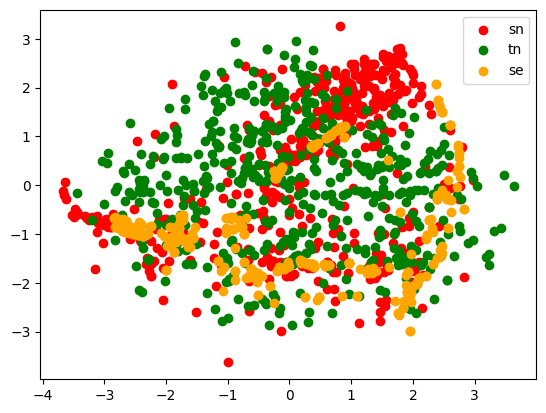

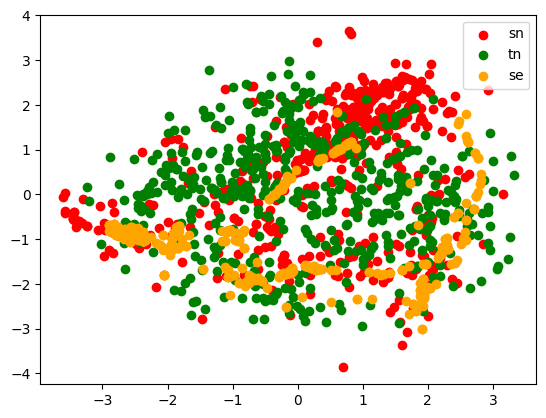

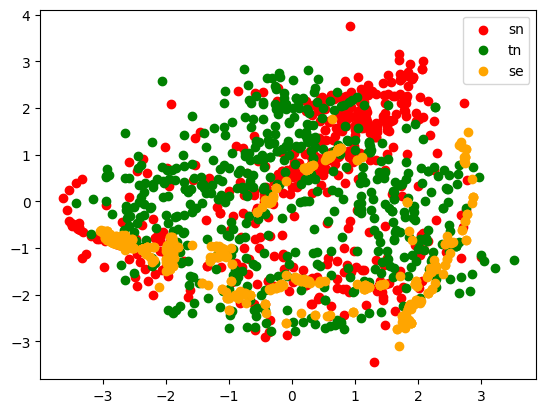

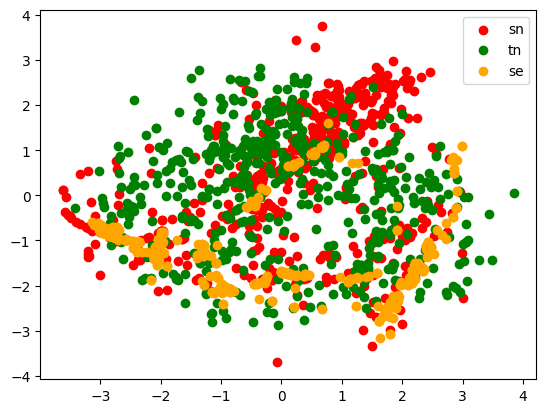

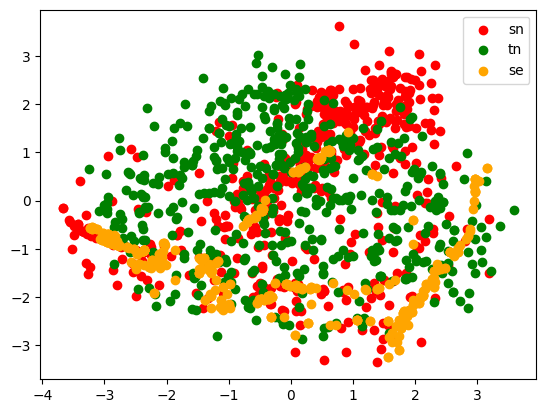

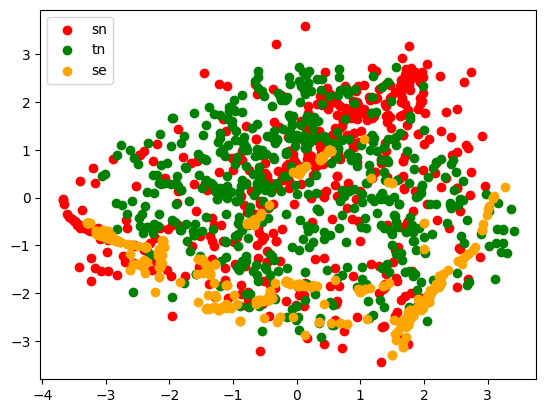

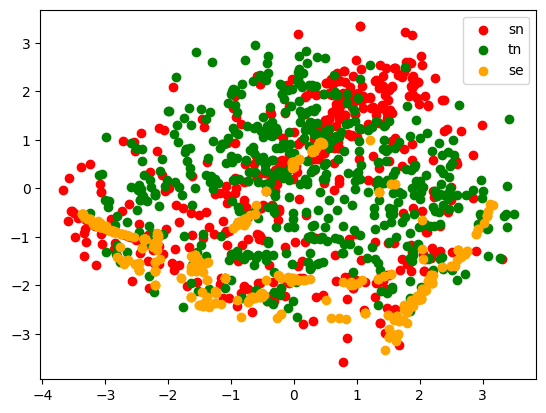

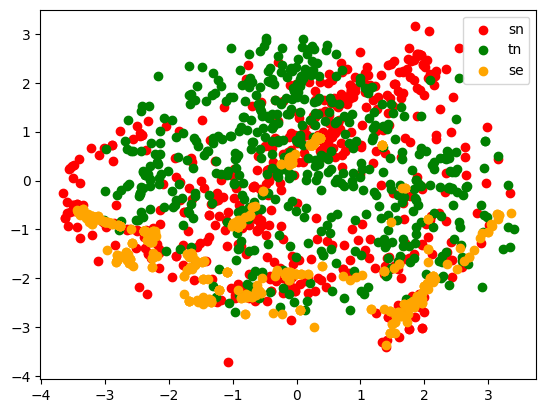

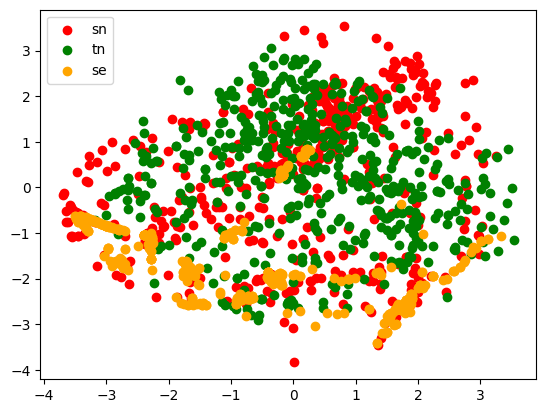

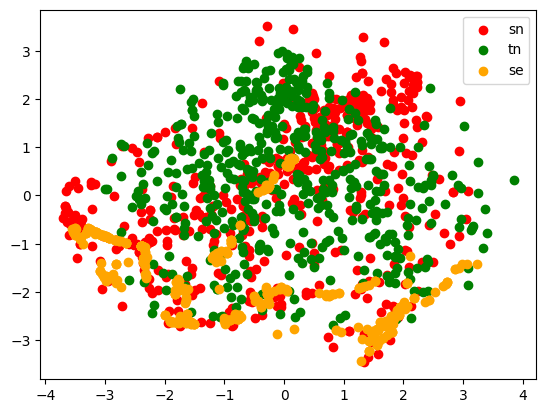

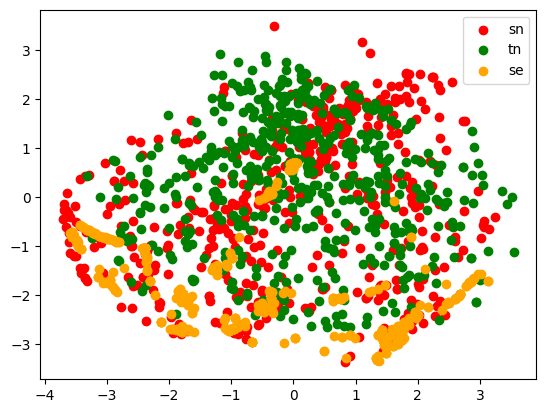

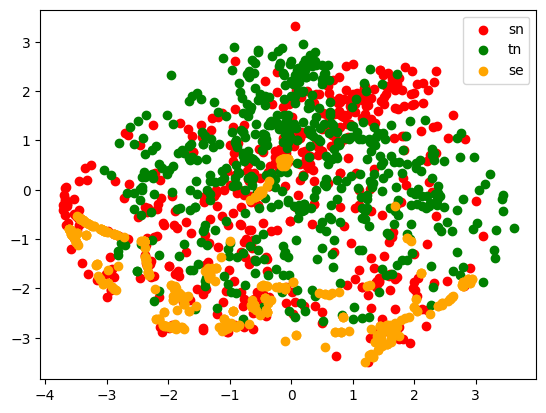

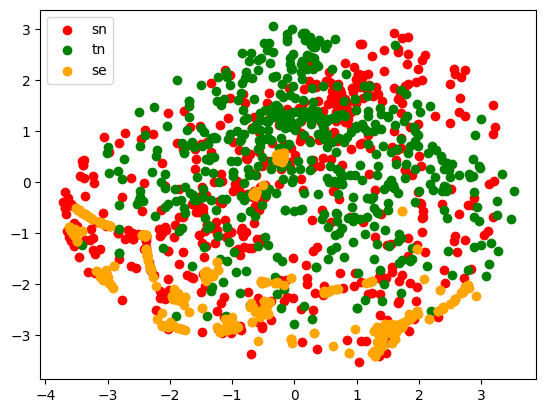

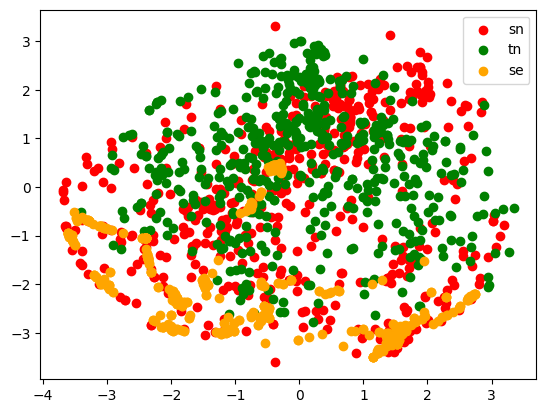

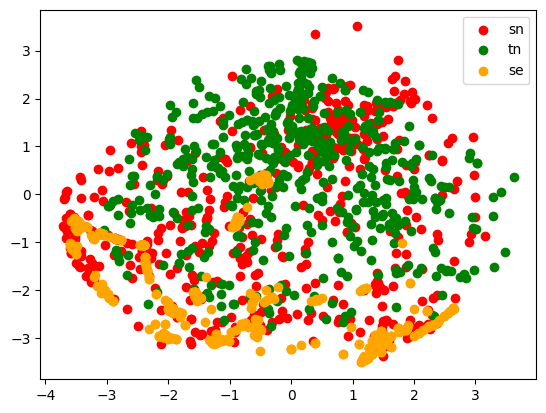

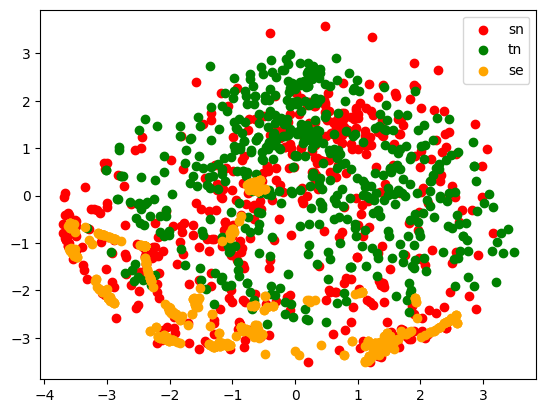

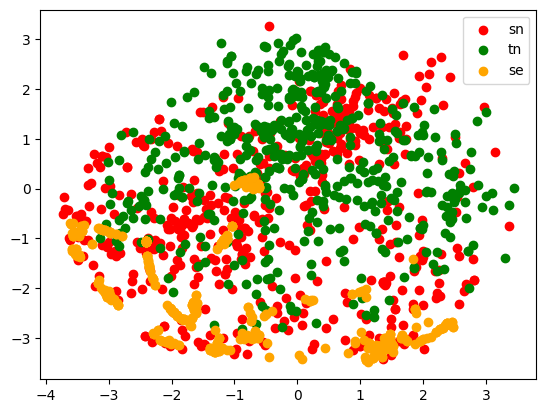

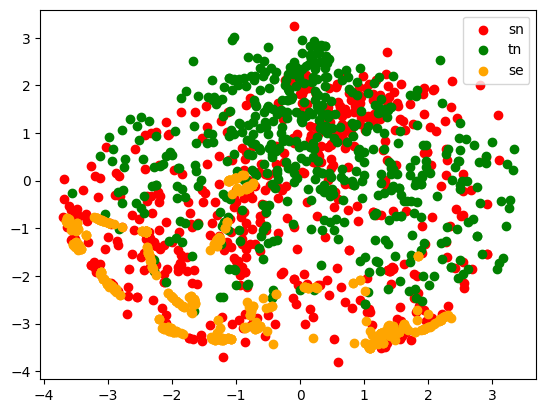

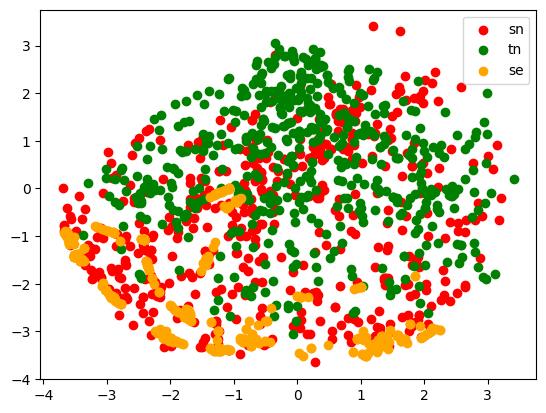

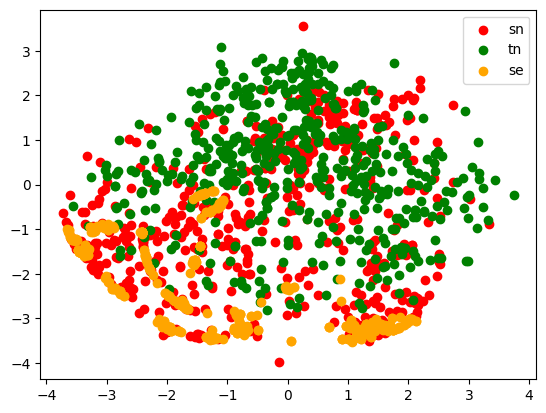

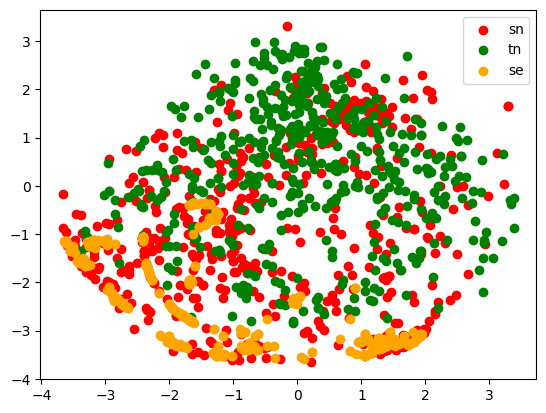

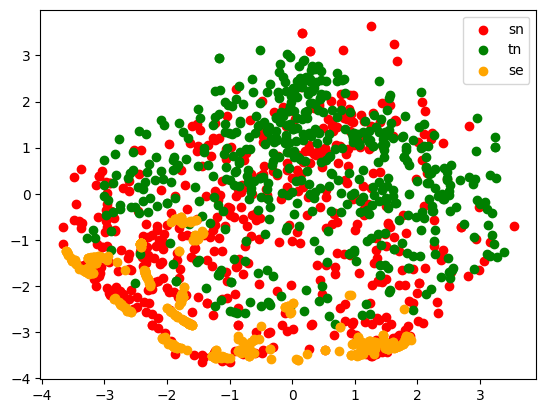

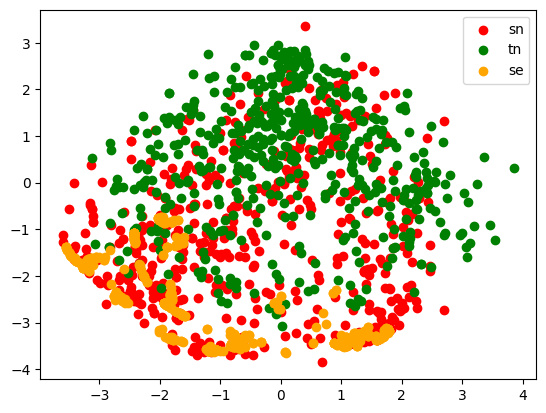

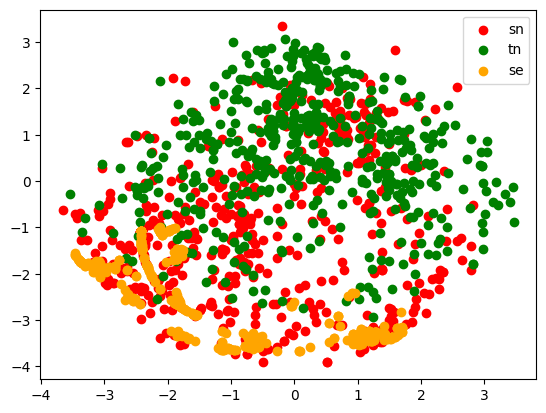

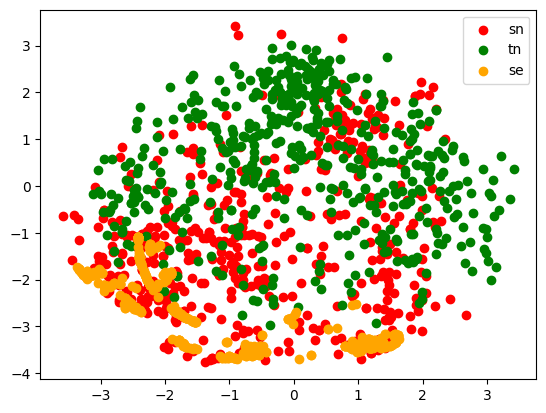

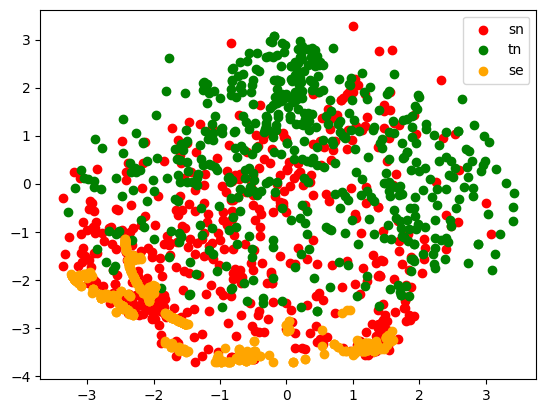

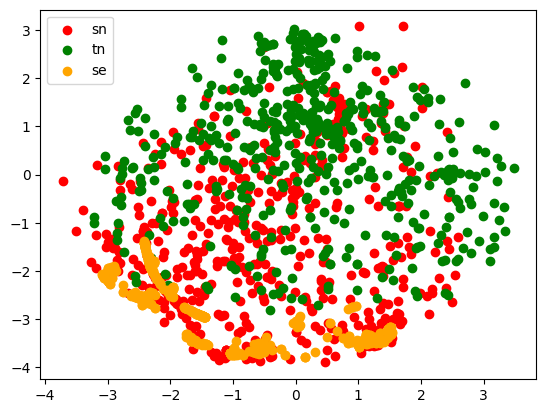

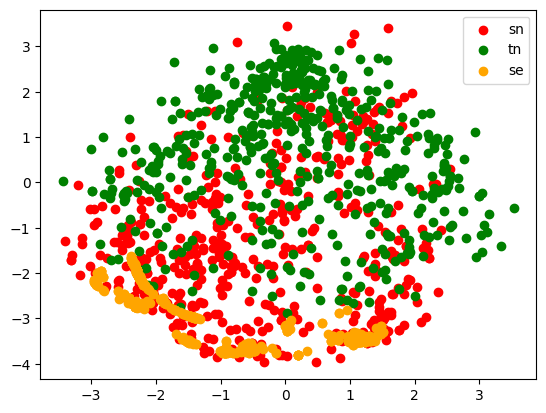

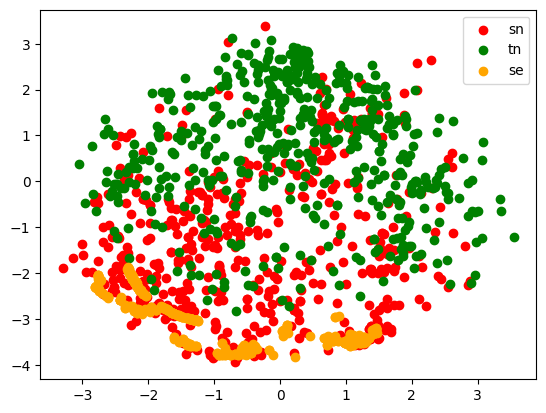

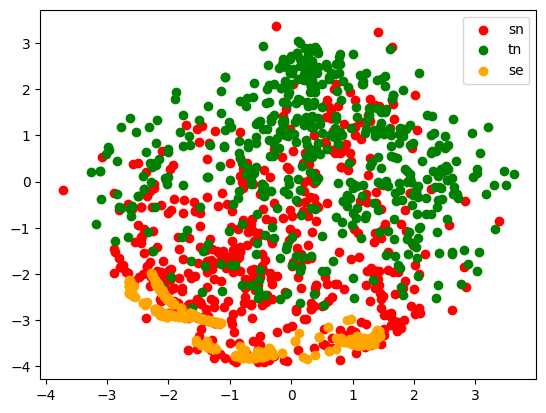

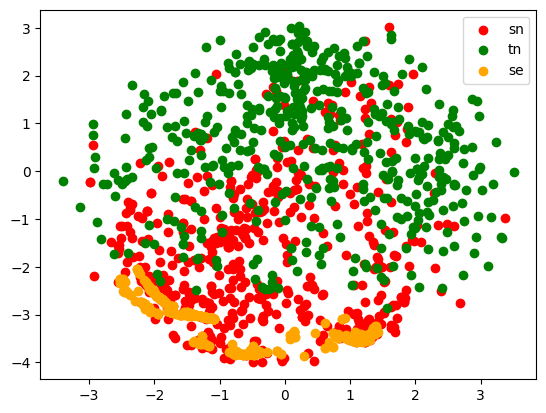

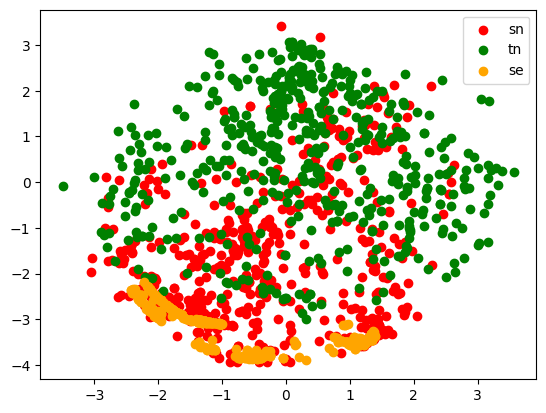

In [12]:
from tqdm.notebook import tqdm
from IPython import display
%matplotlib inline

pbar = tqdm(range(2_000), leave=True)

for i in pbar:
    try:
        agent_data = agent_target_ds.sample(512)
        expert_data = expert_source_ds.sample(512)
        random_data = non_expert_source_ds.sample(512)
        loss_elem, loss_pairs, w_dist_elem, w_dist_pairs = agent.optimize_not(agent_data, expert_data, random_data)
        if i % 25 == 0:
            info = agent.optimize_encoders(agent_data, expert_data, random_data)
            info = jax.tree_map(lambda x: x.item(), info)
        if i % 50 == 0:
        # pbar.set_postfix(info)
            se = agent.encoders_state(expert_data.observations, method='encode_expert')
            sa = agent.encoders_state(agent_data.observations, method='encode_agent')
            sink = sinkhorn_loss(sa, se)
            #print(loss_elem, loss_pairs, w_dist_elem, w_dist_pairs, sink)
            res = {"sink_dist": sink.item(),
                "w_dist_elem": w_dist_elem.item()}
            res.update(info)
            pbar.set_postfix(res)
            fig, ax = plt.subplots()

            sn = agent.encoders_state(random_data.observations, method='encode_expert')
            se = agent.encoders_state(expert_data.observations, method='encode_expert')
            tn = agent.encoders_state(agent_data.observations, method='encode_agent')

            ax.scatter(sn[:, 0], sn[:, 1], c='red', label='sn')
            ax.scatter(tn[:, 0], tn[:, 1], c='green', label='tn')
            ax.scatter(se[:, 0], se[:, 1], c='orange', label='se')
            plt.legend()
            display.display(plt.gcf())
            display.clear_output(wait=True)
    except KeyboardInterrupt:
        break
        

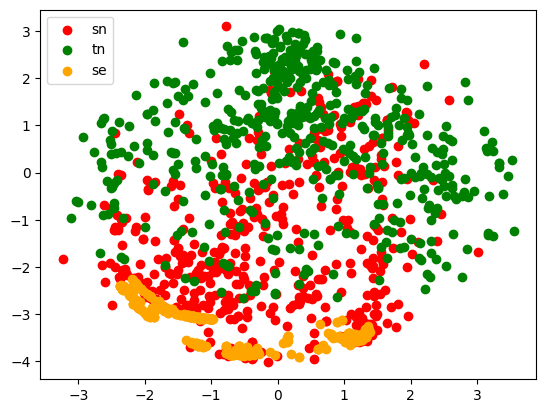

In [13]:
fig, ax = plt.subplots()

sn = agent.encoders_state(random_data.observations, method='encode_expert')
se = agent.encoders_state(expert_data.observations, method='encode_expert')
tn = agent.encoders_state(agent_data.observations, method='encode_agent')

ax.scatter(sn[:, 0], sn[:, 1], c='red', label='sn')
ax.scatter(tn[:, 0], tn[:, 1], c='green', label='tn')
ax.scatter(se[:, 0], se[:, 1], c='orange', label='se')
plt.legend()
plt.show()